# Obtaining a list of equities tickers and the corresponding timeseries

In [1]:
import os
import random
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(10,8)})
import matplotlib.pyplot as plt

import pandas_datareader.data as web
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Configure filepaths for data storage
data_dir = "data"
gdata_dir ="/content/drive/My Drive/Colab Notebooks/data/"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Get list of companies in Dow-Jones Industrial Average (DJIA)

We will obtain and store the list of the constituents from Wikipedia.

In [24]:
today = datetime.today().strftime('%Y-%m-%d')
print(today)

data    = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#Components')
table   = data[1]
symbols = list(table.Symbol.values)
df = pd.DataFrame(symbols, columns=['Symbol'])

print("{} symbols in total".format(len(df)))

2021-04-01
30 symbols in total


## Download price timeseries

Now that we have a list of ticker symbols, we can download the corresponding timeseries from Yahoo Finance.

In [26]:
start_date = '2000-01-01'
end_date  = '2020-12-31'

symbols = sorted(symbols)
print("Downloading {} files".format(len(symbols)))
for i, symbol in enumerate(symbols):
    try:
        df = web.DataReader(symbol,'yahoo', start_date, end_date)
        df = df[['Adj Close','Volume']]
        df.to_csv(os.path.join(data_dir, "{}.csv".format(symbol)))
        df.to_csv(gdata_dir+symbol+".csv")
    except KeyError:
      print("Error for {}".format(symbol))
      pass
print("Stored {} files".format(i+1))

Stored 30 files


In [28]:
# Printing a sample dataframe
idx = np.random.randint(len(symbols))
print("History for {}".format(symbols[idx]))
df = pd.read_csv(os.path.join(data_dir, symbols[idx]+".csv")).set_index('Date')
df.head()

History for DOW


,Adj Close,Volume
Date,,
2019-03-20,44.312790,2350800.0
2019-03-21,43.583141,1764700.0
2019-03-22,43.245010,844700.0
2019-03-25,43.734417,440900.0
2019-03-26,43.467468,504700.0


## Pre-process Financial Timeseries

In [29]:
index = pd.date_range(start=start_date, end=end_date, freq='D')     # initialize an empty DateTime Index
df_price = pd.DataFrame(index=index, columns=symbols)               # initialize empty dataframes
df_volume = pd.DataFrame(index=index, columns=symbols)

In [30]:
# Aggregate all symbols into a price dataframe and volume dataframe
for symbol in symbols:
    symbol_df = pd.read_csv(os.path.join(data_dir, symbol+".csv")).set_index('Date')
    symbol_df.index = pd.to_datetime(symbol_df.index)

    df_price[symbol] = symbol_df['Adj Close']
    df_volume[symbol] = symbol_df['Volume']

### Removing NaNs

In [31]:
# Let's drop the dates where all the stocks are NaNs, ie., weekends/holidays where no trading occured
df_price.dropna(how='all', inplace=True)
df_volume.dropna(how='all', inplace=True)
assert((df_price.index == df_volume.index).all())

Let's see how many NaNs exist at this point, as some companies would've gone public later than others (so they won't have equally long price histories)

In [32]:
pd.isnull(df_price).sum()

AAPL       0
AMGN       0
AXP        0
BA         0
CAT        0
CRM     1122
CSCO       0
CVX        0
DIS        0
DOW     4832
GS         0
HD         0
HON        0
IBM        0
INTC       0
JNJ        0
JPM        0
KO         0
MCD        0
MMM        0
MRK        0
MSFT       0
NKE        0
PG         0
TRV        0
UNH        0
V       2063
VZ         0
WBA        0
WMT        0
dtype: int64

In [33]:
# Backfill NaNs followed by forward fill
df_price = df_price.bfill(axis='rows')   
df_price = df_price.ffill(axis='rows')

In [19]:
pd.isnull(df_price).sum()

AAPL    0
AMGN    0
AXP     0
BA      0
CAT     0
CRM     0
CSCO    0
CVX     0
DIS     0
DOW     0
GS      0
HD      0
HON     0
IBM     0
INTC    0
JNJ     0
JPM     0
KO      0
MCD     0
MMM     0
MRK     0
MSFT    0
NKE     0
PG      0
TRV     0
UNH     0
V       0
VZ      0
WBA     0
WMT     0
dtype: int64

### Storing the cleaned dataframes

In [48]:
df_price.to_csv(gdata_dir+"prices.csv")
df_volume.to_csv(gdata_dir+"volume.csv")
df_price.to_csv(os.path.join(data_dir, "prices.csv"))
df_volume.to_csv(os.path.join(data_dir, "volume.csv"))

## Obtain Percentage Change and Correlation

We need to convert prices to percent change in price as opposed to the actual \$ price. This is because stocks with very similar prices can behave very differently and vice-versa.
For e.g., if a stock moves from $100 to $110, we want the price column to say 10% (indicating the change).

However, for volume, we will retain magnitude.

In [49]:
df_price_pct = df_price.pct_change().dropna(how='all')
df_volume_pct = df_volume.pct_change().dropna(how='all')

### Calculate Correlations

In [50]:
price_corr = df_price_pct.corr()
volume_corr = df_volume.corr()

Text(0.5, 1.0, 'Correlation heatmap for Volume')

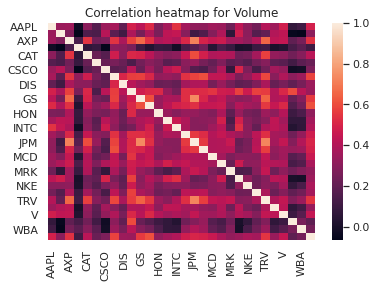

In [51]:
sns.heatmap(volume_corr).set_title("Correlation heatmap for Volume")

Text(0.5, 1.0, 'Correlation heatmap for Price Changes')

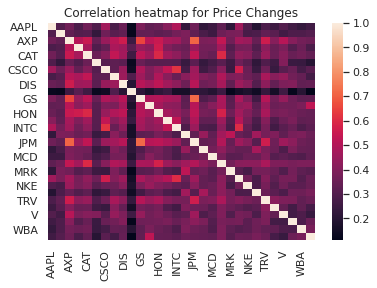

In [52]:
sns.heatmap(price_corr).set_title("Correlation heatmap for Price Changes")

### Examining correlations further
As we can see above, the price histories of JP Morgan (JPM) and Goldman Sachs (GS) are highly correlated. This makes sense as they are both financial sector stocks. That forms the motivation behind using correlation to form the graph.

This can be observed in the plots below.

Text(0.5, 1.0, 'Price Change Scatterplot between JPM and GS. Correlation = 0.7210607728876005')

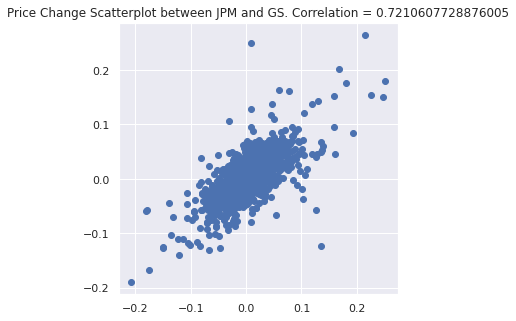

In [53]:
plt.figure(figsize=(5,5))
plt.scatter(df_price_pct['JPM'], df_price_pct['GS'])
plt.title('Price Change Scatterplot between JPM and GS. Correlation = {}'.format(price_corr['JPM']['GS']))

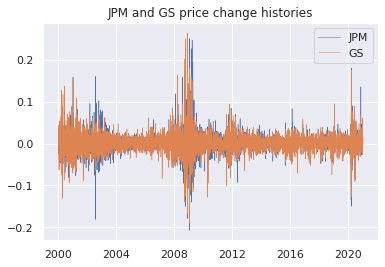

In [54]:
plt.title('JPM and GS price change histories')
plt.plot(df_price_pct['JPM'], label='JPM', linewidth=0.5)
plt.plot(df_price_pct['GS'], label='GS', linewidth=0.5)
plt.legend()

## Saving correlation dataframes

In [55]:
df_price_pct.to_csv(os.path.join(data_dir, 'price_pct.csv'))
price_corr.to_csv(os.path.join(data_dir, 'price_corr.csv'))
volume_corr.to_csv(os.path.join(data_dir, 'volume_corr.csv'))
df_price_pct.to_csv(gdata_dir+'price_pct.csv')
price_corr.to_csv(gdata_dir+'price_corr.csv')
volume_corr.to_csv(gdata_dir+'volume_corr.csv')

### You can now use these correlations to create graphs. 